<a href="https://colab.research.google.com/github/ylmgrbzz/Airline-Passenger-Number-Forecast-with-RNN-Deep-Learning/blob/main/Airline_Passenger_Number_Forecast_with_RNN_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime as dt
import numpy as np
import urllib
import pandas as pd
import seaborn as sns
import random ,os ,glob
import matplotlib.pyplot as plt
import cv2
from imutils import paths
import itertools
from sklearn.utils import shuffle
from urllib.request import urlopen
import warnings
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense,Dropout,SpatialDropout2D,SimpleRNN


In [2]:
warnings.filterwarnings('ignore')

In [3]:
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
df=pd.read_csv("passengers.csv")

In [5]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [7]:
df.columns=["Month","Passengers"]

In [8]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [9]:
df.shape

(145, 2)

In [10]:

df.dtypes

Month          object
Passengers    float64
dtype: object

In [11]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [13]:
df=df[:144]

In [14]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [16]:
df["Month"]=pd.to_datetime(df["Month"])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [18]:
print(df["Month"].min())

1949-01-01 00:00:00


In [19]:
print(df["Month"].max())

1960-12-01 00:00:00


In [20]:
df.index=df["Month"]

In [21]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [22]:
df.drop("Month",axis=1, inplace=True)

In [23]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [24]:
results_df=df.copy()

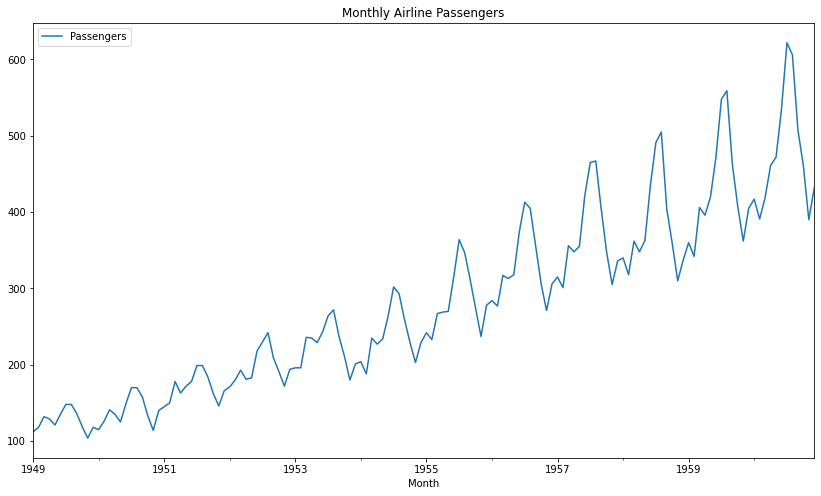

In [25]:
df.plot(figsize=(14,8),title="Monthly Airline Passengers")

In [26]:
data=df["Passengers"].values

In [27]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [28]:
type(data[0:5])

numpy.ndarray

In [29]:
type(data[0])

numpy.float64

In [30]:
data=data.astype("float32")

In [31]:

data.shape

(144,)

In [32]:
data=data.reshape(-1,1)

In [33]:

data.shape

(144, 1)

In [34]:
def split_data(dataframe,test_size):
  position=int(round(len(dataframe)*(1-test_size)))
  train=dataframe[:position]
  test=dataframe[position:]
  return train,test,position

In [35]:
train,test,position=split_data(data,0.33)

In [36]:
print(train.shape,test.shape
)

(96, 1) (48, 1)


In [37]:
scaler_train=MinMaxScaler(feature_range=(0,1))

In [38]:
train=scaler_train.fit_transform(train)


In [39]:
scaler_test=MinMaxScaler(feature_range=(0,1))

In [40]:
test=scaler_test.fit_transform(test)


In [41]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [42]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [43]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [44]:
lookback=1

In [45]:
X_train,y_train=create_features(train,lookback)

In [46]:
X_test,y_test=create_features(test,lookback)

In [47]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [48]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [49]:
model = Sequential()
model.add(SimpleRNN(units=50,activation='relu', 
                    input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.20))
model.add(Dense(1))


In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [52]:
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1, mode='min'),
        ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',save_best_only=True,save_weights_only=False,verbose=1)]

In [53]:
history=model.fit(x=X_train,y=y_train, epochs=50, batch_size=1,callbacks=callbacks,validation_data=(X_test,y_test),shuffle=False)


Epoch 1/50
90/95 [===========================>..] - ETA: 0s - loss: 0.0130
Epoch 1: val_loss improved from inf to 0.03594, saving model to mymodel.h5
95/95 [==============================] - 4s 6ms/step - loss: 0.0143 - val_loss: 0.0359
Epoch 2/50
88/95 [==========================>...] - ETA: 0s - loss: 0.0187
Epoch 2: val_loss improved from 0.03594 to 0.02433, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0200 - val_loss: 0.0243
Epoch 3/50
90/95 [===========================>..] - ETA: 0s - loss: 0.0145
Epoch 3: val_loss improved from 0.02433 to 0.02184, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0218
Epoch 4/50
91/95 [===========================>..] - ETA: 0s - loss: 0.0119
Epoch 4: val_loss improved from 0.02184 to 0.02076, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0208
Epoch 5/50
92/95 [======================

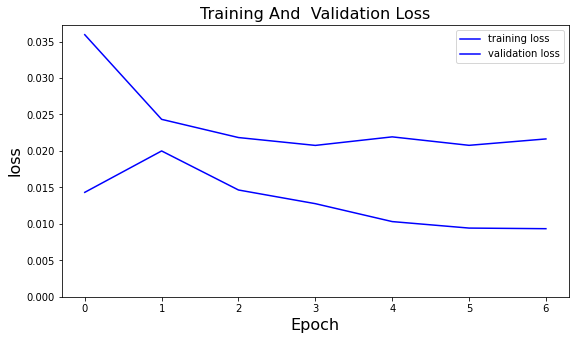

In [54]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],color="b",label="training loss")
plt.plot(history.history["val_loss"],color="b",label="validation loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training And  Validation Loss",fontsize=16)
plt.show()

In [55]:
loss=model.evaluate(X_test,y_test,batch_size=1)
print(100.0*loss)

47/47 [==============================] - 0s 2ms/step - loss: 0.0216
2.16465350240469


In [56]:
train_predict=model.predict(X_train)

3/3 [==============================] - 0s 4ms/step


In [57]:
test_predict=model.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [58]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [59]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [60]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))

In [61]:
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))

In [62]:
print(train_rmse)


25.321005


In [63]:
print(test_rmse)


47.227974


In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [65]:
train_prediction_df=results_df[lookback:position]


In [66]:
train_prediction_df["Predicted"]=train_predict

In [67]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,137.514557
1949-03-01,132.0,141.599182
1949-04-01,129.0,152.208618
1949-05-01,121.0,149.935150
1949-06-01,135.0,143.872635


In [71]:
test_prediction_df= results_df[position+lookback:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,339.647308
1957-03-01,356.0,330.998810
1957-04-01,348.0,374.441040
1957-05-01,355.0,367.215149
1957-06-01,422.0,373.537842


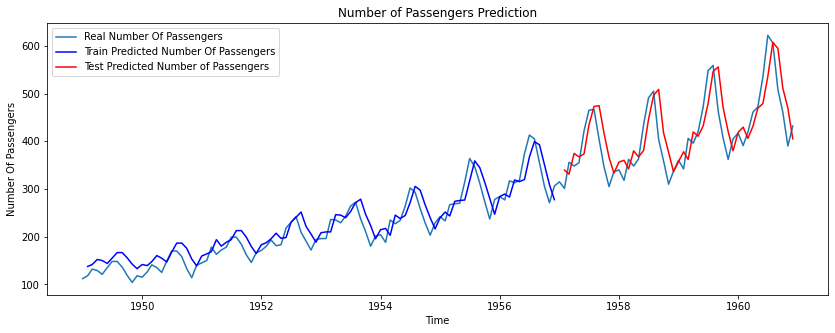

In [72]:
plt.figure(figsize=(14,5))
plt.plot(results_df,label="Real Number Of Passengers")
plt.plot(train_prediction_df["Predicted"],color="blue",label="Train Predicted Number Of Passengers")
plt.plot(test_prediction_df["Predicted"],color="red",label="Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number Of Passengers")
plt.legend()
plt.show()